In [1]:
import scipy.optimize
import numpy as np
import matplotlib.pyplot as plt
import warnings
from isca_tools.plot import fig_resize, update_fontsize, update_linewidth, savefig, label_subplots
from isca_tools.thesis.mod_parcel_theory import get_sensitivity_factors
warnings.filterwarnings('ignore')
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [2]:
width = {'one_col': 3.2, 'two_col': 5.5}  # width in inches
im_sz = 1.5
plt.style.use('/Users/joshduffield/Documents/StAndrews/Isca/jobs/tau_sweep/aquaplanet/publish_figures/publish.mplstyle')
ax_linewidth = plt.rcParams['axes.linewidth']

## Schematics
Copied from code used for [paper](https://github.com/jduffield65/Isca/blob/main/jobs/tau_sweep/land/meridional_band/publish_figures/generate_all_paper_figs.ipynb).

Make schematics to illustrate physical mechanisms, with an approximate moist lapse rate following exponential decay with temperature.

In figures, dashed lines indicate current climate. Dotted lines are if warm at FT with no lapse rate change. Black lines indicate day with no CAPE in current climate and no RH or CAPE change with warming. Red lines indicate change according to mechanism under consideration, which results in amplified warming. Dotted blue lines indicate moist adiabatic profile given surface conditions.

In [4]:
labels_cont = {'temp_ft_change': 'FT change', 'rh_change': 'RH change', 'sCAPE_change': 'CAPE change',
               'temp_surf_anom': 'Hot-get-hotter', 'rh_anom': 'Drier-get-hotter', 'lapse_D_change': '$\eta_D$ change',
               'lapse_M_change': '$\eta_M$ change', 'lapse_D_anom': '$\eta_D$ climatological'}
leg_handlelength = 1.5

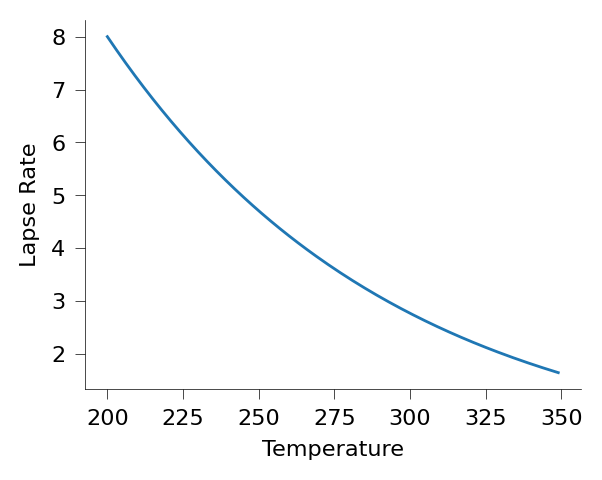

In [5]:
# Define approximate moist lapse rate to follow exponential decay function, so near dry adiabat at low temperatures and moist adiabat at high temp
def moist_lapse_exp_decay(x, dry_lapse=10, temp_dry=200, temp0=350, decay_sigma=10):
    # Define approximate moist lapse rate to follow exponential decay function, so equal 0.8*dry lapse rate at temp_dry, and nearly zero at temp0.
    # Decay_sigma controlls the rate of the decay with temperature, smaller means more rapid decay
    # Given conditions
    x_start, x_end = temp_dry, temp0
    y_start, y_end = 0.8 * dry_lapse, 1e-6  # Assume nearly zero at x=300

    # Solve for decay rate k
    k = np.log(y_start / y_end) / (x_end - x_start)
    return y_start * np.exp(-k * (x - x_start) / decay_sigma)


fig, ax = plt.subplots(1, 1)
fig_resize(fig, width['one_col'])
ax.plot(np.arange(200, 350), moist_lapse_exp_decay(np.arange(200, 350), 10))
ax.set_xlabel('Temperature')
ax.set_ylabel('Lapse Rate')
update_fontsize(fig)
update_linewidth(fig)
plt.show()

In [6]:
schem_info = {'lapse_dry': 10,
              'lapse_moist': moist_lapse_exp_decay,
              'height': np.linspace(0, 10, 1000),
              # moist lapse rate decreases from lapse dry to 0, between 200K and 300K
              'temp_ft0': 240,
              'lcl0': 3,
              'lcl_large': 7,
              'temp_ft_change': 50,
              'temp_anom': 85,
              'color_mech': 'C3',
              'color_cape': 'C3',
              'linestyle_cape': '-.',
              'dash_cape': [10, 4, 1, 5],  # Dash, Gap, Dot, Gap
              'lapse_moist_change': 4,
              'lapse_dry_change': 10,
              'lapse_dry_anom': -6,
              }


def get_schem_profile(temp_ft=schem_info['temp_ft0'], lcl=schem_info['lcl0'], height=schem_info['height'],
                      lapse_moist_mod=0,
                      lapse_dry_mod=0):
    # Lapse_moist_mod is epsilon or CAPE, larger means more CAPE i.e. lapse rate further from moist, closer to dry adiabat
    temp_profile = np.zeros_like(height)
    temp_profile[height >= lcl] = temp_ft + (schem_info['lapse_moist'](temp_ft) + lapse_moist_mod) * (
            height[-1] - height[height >= lcl])
    lcl_ind = np.where(height >= lcl)[0][0]
    temp_profile[height < lcl] = temp_profile[lcl_ind] + (schem_info['lapse_dry'] + lapse_dry_mod) * (
            height[lcl_ind] - height[height < lcl])
    return temp_profile


def get_schem_profile_from_surf(temp_surf, lcl=schem_info['lcl0'], height=schem_info['height'], lapse_moist_mod=0,
                                lapse_dry_mod=0):
    def func_to_minimize(x):
        # Find surface temperature of profile given x as temp_ft
        # Return difference between this and desired temp_surf
        return np.abs(get_schem_profile(x, lcl, height, lapse_moist_mod, lapse_dry_mod)[0] - temp_surf)

    # First find ft temperature that gives the surface temperature
    temp_ft_use = scipy.optimize.minimize_scalar(func_to_minimize, bounds=(200, 380), method="bounded").x
    return get_schem_profile(temp_ft_use, lcl, height, lapse_moist_mod, lapse_dry_mod)


schem_info['temp_s0'] = get_schem_profile()[0]  # surface temperature in reference climate

In [7]:
def move_axis_to_center(ax):
    # Get positions of original left and right bottom subplots
    pos_left = ax[1, 0].get_position()
    pos_right = ax[1, 1].get_position()  # any other plot in same column to get width

    # Compute center of the row
    row_center = (pos_left.x0 + pos_right.x0 + pos_right.width) / 2
    new_x0 = row_center - pos_left.width / 2

    # Move the bottom-left subplot to row center
    ax[1, 0].set_position([new_x0, pos_left.y0, pos_left.width, pos_left.height])

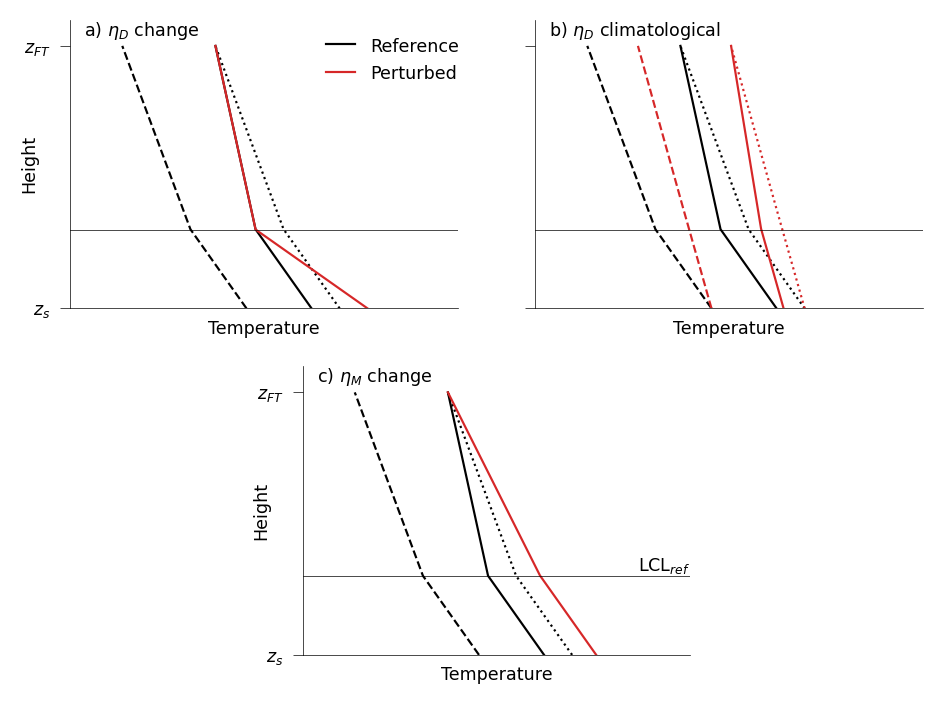

In [8]:
fig, ax = plt.subplots(2, 2, sharex=True, sharey=True)
fig_resize(fig, width['two_col'])
ax[1, 1].remove()
move_axis_to_center(ax)

# Plot change along moist adiabat in all figures
for i, ax_use in enumerate(ax.flatten()):
    ax_use.plot(get_schem_profile(), schem_info['height'], color='k', linestyle='--')
    ax_use.plot(get_schem_profile() + schem_info['temp_ft_change'], schem_info['height'], color='k', linestyle=':')
    # Remove axis info
    ax_use.plot(get_schem_profile(schem_info['temp_ft0'] + schem_info['temp_ft_change']), schem_info['height'],
                color='k', label='Reference')
    ax_use.set_xticks([])
    ax_use.set_yticks([0, 10], ['$z_s$', '$z_{FT}$'])
    ax_use.set_xlabel('Temperature')
    # ax_use.tick_params(axis='both', which='both', length=0)
    # ax_use.set_xticklabels([])
    # ax_use.set_yticklabels([])

# lapse_D Change
ax[0, 0].plot(get_schem_profile(schem_info['temp_ft0'] + schem_info['temp_ft_change'],
                                lapse_dry_mod=schem_info['lapse_dry_change']),
              schem_info['height'], color=schem_info['color_mech'],
              label='Perturbed')

# lapse_D climatological
schem_profile0 = get_schem_profile_from_surf(schem_info['temp_s0'], lapse_dry_mod=schem_info['lapse_dry_anom'])
ax[0, 1].plot(schem_profile0, schem_info['height'], color=schem_info['color_mech'], linestyle='--')
ax[0, 1].plot(
    get_schem_profile(schem_profile0[-1] + schem_info['temp_ft_change'], lapse_dry_mod=schem_info['lapse_dry_anom']),
    schem_info['height'], color=schem_info['color_mech'])
ax[0, 1].plot(schem_profile0 + schem_info['temp_ft_change'], schem_info['height'],
              color=schem_info['color_mech'], linestyle=':')

# lapse_M Change
ax[1, 0].plot(get_schem_profile(schem_info['temp_ft0'] + schem_info['temp_ft_change'],
                                lapse_moist_mod=schem_info['lapse_moist_change']),
              schem_info['height'], color=schem_info['color_mech'],
              label='Perturbed')

ax[0, 0].get_xlim()
ax[0, 0].set_xlim(212, 420)
ax[0, 0].set_ylim(0, schem_info['height'][-1] + 1)
for i in range(2):
    ax[i, 0].set_ylabel('Height', labelpad=-5)

# Put titles in letter labels to avoid looking like x axis labels
letter_order = ['a', 'c', 'b']
label_subplots(fig, ax.transpose().flatten()[:-1], [f"{letter_order[i]}) " + labels_cont[key] for i, key in
                                                    enumerate(['lapse_D_change', 'lapse_M_change', 'lapse_D_anom'])],
               box_alpha=0, pos_y=0)

ax[1, 0].text(ax[1, 0].get_xlim()[1], schem_info['lcl0'], "LCL$_{ref}$", color='k', va='bottom', ha='right')
# ax.text(100, -0.05, "Lapse Rate", color='k', va='top', ha='right')

update_linewidth(fig)
ax[0, 0].legend(loc='upper right', bbox_to_anchor=(1.05, 1), handlelength=leg_handlelength)
update_fontsize(fig)

for ax_use in ax.flatten():
    ax_use.axhline(schem_info['lcl0'], color='k', lw=ax_linewidth)
#plt.subplots_adjust(wspace=0.08)            # move axis closer together
plt.show()
# savefig(fig)

## Sensitivity Parameters
Here I plot the sensitivity parameters for the lapse rate mechanisms without any normalization, copied from code used to create figures for [paper](https://github.com/jduffield65/Isca/blob/main/jobs/tau_sweep/land/meridional_band/publish_figures/generate_all_paper_figs.ipynb).

In [9]:
n_temp_gamma_plot = 81
n_rh_gamma_plot = 101
temp_gamma_plot = np.linspace(285, 333, n_temp_gamma_plot)
rh_gamma_plot = np.linspace(0.2, 0.8, n_rh_gamma_plot)
gamma = {key: np.zeros((n_temp_gamma_plot, n_rh_gamma_plot)) for key in
         ['lapse_D_change', 'lapse_M_change', 'lapse_D_anom']}

for i in range(n_temp_gamma_plot):
    for j in range(n_rh_gamma_plot):
        var = get_sensitivity_factors(temp_gamma_plot[i], rh_gamma_plot[j], pressure_surf=1000 * 100,
                                      pressure_ft=500 * 100, temp_surf_lcl_calc=300)
        for key in gamma:
            gamma[key][i, j] = var[key]

In [10]:
gamma_plot_levels = {'lapse_D_change': np.asarray([0.08, 0.16, 0.24, 0.32]),
                     'lapse_M_change': np.asarray([0.3, 0.35, 0.4, 0.45, 0.5]),
                     'lapse_D_anom': {'pos': np.asarray([0.001, 0.002, 0.003]),
                                      'neg': np.asarray([-0.003, -0.001])}
                     }
gamma_plot_labels = {'lapse_D_change': '$\gamma_{\delta \eta_D}$ [KK$^{-1}$]',
                     'lapse_M_change': '$\gamma_{\delta \eta_M}$ [K%$^{-1}$]',
                     'lapse_D_anom': '$\gamma_{\Delta \eta_D}/\overline{T}_s$ [K$^{-1}$]'}
# Make sure gamma prefactor has RH in units of % when dividing
gamma_prefactor = {'lapse_D_change': 1, 'lapse_M_change': 1,
                   'lapse_D_anom': 1 / temp_gamma_plot[:, np.newaxis]}
# Manually position each contour label so does not overlap with title
clabel_pos = {'lapse_D_change': [(72, 310), (50, 310), (40, 310), (0, 310)],
              'lapse_M_change': [(20, 305), (35, 305), (50, 310), (55, 314), (60, 320), (70, 280)],
              'lapse_D_anom': {'pos': [(75, 320), (50, 320), (30, 320)],
                               'neg': [(28, 300), (28, 290)]}
              }

lw_contour = 0.2
fontsize_contour = 5

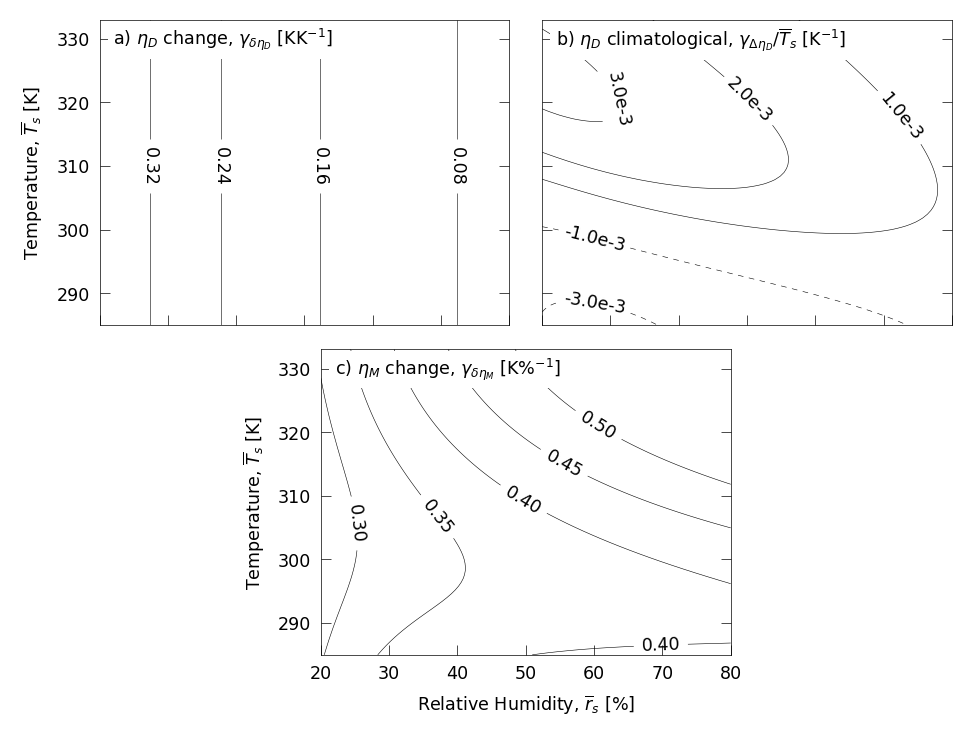

In [11]:
import matplotlib.ticker as ticker


def sci_no_leading_zero(x, _, n_decimal=None):
    if n_decimal == 1:
        return f"{x:.1e}".replace("e+0", "e").replace("e+", "e").replace("e0", "e0").replace("e-0", "e-")
    elif n_decimal is None:
        return f"{x:.0e}".replace("e+0", "e").replace("e+", "e").replace("e0", "e0").replace("e-0", "e-")


# fmt = ticker.FuncFormatter(lambda x, _: f"{x:.1e}")
fmt_no_decimal = ticker.FuncFormatter(lambda x, _: sci_no_leading_zero(x, _, None))
fmt_decimal = ticker.FuncFormatter(lambda x, _: sci_no_leading_zero(x, _, 1))
fmt = {'lapse_D_change': None, 'lapse_M_change': None, 'lapse_D_anom': fmt_decimal, 'r_anom': fmt_no_decimal}

fig, ax = plt.subplots(2, 2, sharex=True, sharey=True)
fig_resize(fig, width['two_col'])
ax[1, 1].remove()
ax_array = ax           # so can move to center later
ax = ax.transpose().flatten()
keys_plot = [key for key in gamma_plot_levels if ('cape' not in key)]
for j, key in enumerate(keys_plot):
    if j < int(np.ceil(len(ax) / 2)):
        ax[j].set_ylabel('Temperature, $\overline{T}_s$ [K]')
    # ax[j].set_title(labels_cont[key]+', '+gamma_plot_labels[key])
    ax[j].spines['right'].set_visible(True)
    ax[j].spines['top'].set_visible(True)
    # ax[j].xaxis.set_ticks_position('both')
    ax[j].yaxis.set_ticks_position('both')
    ax[j].tick_params(axis='both', direction='in')

    var = gamma[key] * gamma_prefactor[key]
    if isinstance(gamma_plot_levels[key], dict):
        var_plot = ax[j].contour(rh_gamma_plot * 100, temp_gamma_plot, np.where(var < 0, np.nan, var),
                                 levels=gamma_plot_levels[key]['pos'], colors='black', linewidths=lw_contour)
        ax[j].clabel(var_plot, inline=True, fontsize=fontsize_contour, fmt=fmt[key], manual=clabel_pos[key]['pos'])
        var_plot = ax[j].contour(rh_gamma_plot * 100, temp_gamma_plot, np.where(var > 0, np.nan, var),
                                 levels=gamma_plot_levels[key]['neg'], colors='black', linewidths=lw_contour)
        ax[j].clabel(var_plot, inline=True, fontsize=fontsize_contour, fmt=fmt[key], manual=clabel_pos[key]['neg'])
        for collection in var_plot.collections:
            # For negative values, increase dash separation, to emphasize negative
            collection.set_linestyle('--')  # Dotted line style
            collection.set_dashes([(0, (10.0, 10.0))])
    else:
        var_plot = ax[j].contour(rh_gamma_plot * 100, temp_gamma_plot, var,
                                 levels=gamma_plot_levels[key], colors='black', linewidths=lw_contour)
        clabels = ax[j].clabel(var_plot, inline=True, fontsize=fontsize_contour, fmt=fmt[key], manual=clabel_pos[key])

ax[-3].set_xlabel('Relative Humidity, $\overline{r}_s$ [%]')
# Put titles in letter labels to avoid looking like x axis labels
letter_order = ['a', 'c', 'b']
label_subplots(fig, ax[:-1],
               [f"{letter_order[i]}) " + labels_cont[key] + ', ' + gamma_plot_labels[key] for i, key in
                enumerate(keys_plot)],
               box_alpha=1, pos_y=-2.5)


update_fontsize(fig)
# update_linewidth(fig)
plt.subplots_adjust(wspace=0.08, hspace=0.08)
move_axis_to_center(ax_array)
# savefig()